**Predict Future Sales**

*   Chandana Gondi - cg525
*   Jatin Manikanta - jk694
*   Sriram Gottipati - sg2495

In [244]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import nltk
import sklearn

In [203]:
train_df = pd.read_csv("sales_train.csv")
test_df = pd.read_csv("test.csv")
items_df = pd.read_csv("items.csv")
item_categories_df = pd.read_csv("item_categories.csv")
shops_df = pd.read_csv("shops.csv")

In [204]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [205]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [206]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [207]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [208]:
shops_df.tail()

,shop_name,shop_id
55,Цифровой склад 1С-Онлайн,55
56,"Чехов ТРЦ ""Карнавал""",56
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58
59,"Ярославль ТЦ ""Альтаир""",59


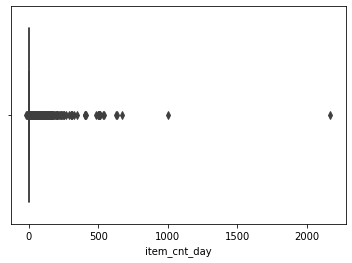

In [209]:
import seaborn as sns
sns.boxplot(x=train_df.item_cnt_day)


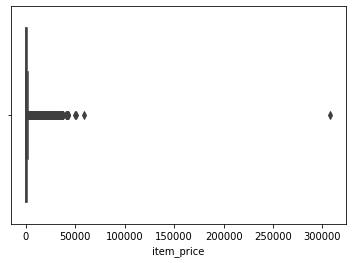

In [210]:
import seaborn as sns
sns.boxplot(x=train_df.item_price)

In [211]:
#Daily data to monthly data
train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y')
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df = train_df.drop(['date', 'item_price'], axis=1)
train_df = train_df.groupby([c for c in train_df.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train_df = train_df.rename(columns={'item_cnt_day':'item_cnt_month'})

shop_item_monthly_mean = train_df[['shop_id', 'item_id', 'item_cnt_month']].groupby(['shop_id', 'item_id'], as_index=False)[['item_cnt_month']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})

train_df = pd.merge(train_df, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean
0,0,0,32,1,2013,6.0,8.0
1,0,0,33,1,2013,3.0,3.0
2,0,0,35,1,2013,1.0,7.5
3,0,0,43,1,2013,1.0,1.0
4,0,0,51,1,2013,2.0,2.5


In [212]:
shop_item_prev_month = train_df[train_df['date_block_num'] == 33][['shop_id', 'item_id', 'item_cnt_month']]
shop_item_prev_month = shop_item_prev_month.rename(columns={'item_cnt_month':'item_cnt_prev_month'})
shop_item_prev_month.head()

,shop_id,item_id,item_cnt_prev_month
1577593,2,31,1.0
1577594,2,486,3.0
1577595,2,787,1.0
1577596,2,794,1.0
1577597,2,968,1.0


In [213]:
train_df = pd.merge(train_df, shop_item_prev_month, how='left', on=['shop_id', 'item_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month
0,0,0,32,1,2013,6.0,8.0,NaN
1,0,0,33,1,2013,3.0,3.0,NaN
2,0,0,35,1,2013,1.0,7.5,NaN
3,0,0,43,1,2013,1.0,1.0,NaN
4,0,0,51,1,2013,2.0,2.5,NaN


In [214]:
np.where(pd.isnull(train_df))

(array([      0,       1,       2, ..., 1577586, 1577587, 1577592]),
 array([7, 7, 7, ..., 7, 7, 7]))

In [215]:
train_df = train_df.fillna(0.)
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month
0,0,0,32,1,2013,6.0,8.0,0.0
1,0,0,33,1,2013,3.0,3.0,0.0
2,0,0,35,1,2013,1.0,7.5,0.0
3,0,0,43,1,2013,1.0,1.0,0.0
4,0,0,51,1,2013,2.0,2.5,0.0


In [216]:
train_df = pd.merge(train_df, items_df, how='left', on='item_id')
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57


In [217]:
train_df = pd.merge(train_df, item_categories_df, how='left', on=['item_category_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40,Кино - DVD
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37,Кино - Blu-Ray
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3


In [218]:
train_df = pd.merge(train_df, shops_df, how='left', on=['shop_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран"
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,"!Якутск Орджоникидзе, 56 фран"


In [219]:
test_df['month'] = 11
test_df['year'] = 2015
test_df['date_block_num'] = 34
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num
0,0,5,5037,11,2015,34
1,1,5,5320,11,2015,34
2,2,5,5233,11,2015,34
3,3,5,5232,11,2015,34
4,4,5,5268,11,2015,34


In [220]:
shop_item_monthly_mean.head()

,shop_id,item_id,item_cnt_month_mean
0,0,30,31.0
1,0,31,11.0
2,0,32,8.0
3,0,33,3.0
4,0,35,7.5


In [221]:
test_df = pd.merge(test_df, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id'])

In [222]:
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean
0,0,5,5037,11,2015,34,1.444444
1,1,5,5320,11,2015,34,NaN
2,2,5,5233,11,2015,34,2.000000
3,3,5,5232,11,2015,34,1.000000
4,4,5,5268,11,2015,34,NaN


In [223]:
test_df = pd.merge(test_df, shop_item_prev_month, how='left', on=['shop_id', 'item_id'])
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month
0,0,5,5037,11,2015,34,1.444444,NaN
1,1,5,5320,11,2015,34,NaN,NaN
2,2,5,5233,11,2015,34,2.000000,1.0
3,3,5,5232,11,2015,34,1.000000,NaN
4,4,5,5268,11,2015,34,NaN,NaN


In [224]:
test_df = pd.merge(test_df, items_df, how='left', on='item_id')
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id
0,0,5,5037,11,2015,34,1.444444,NaN,"NHL 15 [PS3, русские субтитры]",19
1,1,5,5320,11,2015,34,NaN,NaN,ONE DIRECTION Made In The A.M.,55
2,2,5,5233,11,2015,34,2.000000,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19
3,3,5,5232,11,2015,34,1.000000,NaN,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23
4,4,5,5268,11,2015,34,NaN,NaN,"Need for Speed [PS4, русская версия]",20


In [225]:
test_df = pd.merge(test_df, item_categories_df, how='left', on='item_category_id')
test_df = pd.merge(test_df, shops_df, how='left', on='shop_id')
test_df = test_df.fillna(0.)
test_df['item_cnt_month'] = 0.
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name,item_cnt_month
0,0,5,5037,11,2015,34,1.444444,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0
1,1,5,5320,11,2015,34,0.000000,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0.0
2,2,5,5233,11,2015,34,2.000000,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0
3,3,5,5232,11,2015,34,1.000000,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",0.0
4,4,5,5268,11,2015,34,0.000000,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",0.0


In [226]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print("train_df.shape = {}, test_df.shape = {}, train_test_df.shape = {}".format(train_df.shape, test_df.shape, train_test_df.shape))
stores_hm = train_test_df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
print("stores_hm.shape = {}".format(stores_hm.shape))
stores_hm.tail()

train_df.shape = (1609124, 12), test_df.shape = (214200, 13), train_test_df.shape = (1823324, 13)
stores_hm.shape = (60, 84)


item_category_id,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
shop_id,,,,,,,,,,,,,,,,,,,,,
55,1,0,10,28,0,4,9,24,36,8,...,22,44,1503,16,1692,1,3,0,0,4
56,1,0,234,229,31,123,251,62,9,8,...,1,254,61,98,49,25,9,23,53,59
57,1,0,302,281,47,148,266,117,4,8,...,1,977,61,151,49,20,0,14,31,85
58,1,0,218,243,41,111,246,80,1,8,...,1,569,61,82,49,17,0,12,33,61
59,1,0,174,199,27,54,165,73,6,8,...,1,369,61,20,49,20,5,0,0,110


In [227]:
for c in ['shop_name', 'item_category_name', 'item_name']:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(list(train_df[c].unique()) + list(test_df[c].unique()))
    train_df[c] = le.transform(train_df[c].astype(str))
    test_df[c] = le.transform(test_df[c].astype(str))
    print(c)

shop_name
item_category_name
item_name


In [228]:
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name
0,0,0,32,1,2013,6.0,8.0,0.0,32,40,40,0
1,0,0,33,1,2013,3.0,3.0,0.0,33,37,37,0
2,0,0,35,1,2013,1.0,7.5,0.0,35,40,40,0
3,0,0,43,1,2013,1.0,1.0,0.0,43,40,40,0
4,0,0,51,1,2013,2.0,2.5,0.0,51,57,57,0


In [229]:
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name
0,0,0,32,1,2013,6.0,8.0,0.0,32,40,40,0
1,0,0,33,1,2013,3.0,3.0,0.0,33,37,37,0
2,0,0,35,1,2013,1.0,7.5,0.0,35,40,40,0
3,0,0,43,1,2013,1.0,1.0,0.0,43,40,40,0
4,0,0,51,1,2013,2.0,2.5,0.0,51,57,57,0


In [230]:
feature_list = [i for i in train_df.columns if i not in 'item_cnt_month']

In [231]:
X = train_df[train_df['date_block_num'] == 33]
y = np.log1p(X['item_cnt_month'].clip(0., 20.))

In [232]:
X = X.drop('item_cnt_month', axis=1)
X

,date_block_num,shop_id,item_id,month,year,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name
1577593,33,2,31,10,2015,1.600000,1.0,31,37,37,2
1577594,33,2,486,10,2015,1.777778,3.0,486,73,73,2
1577595,33,2,787,10,2015,1.000000,1.0,787,49,49,2
1577596,33,2,794,10,2015,1.000000,1.0,794,73,73,2
1577597,33,2,968,10,2015,1.000000,1.0,968,40,40,2
...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,10,2015,6.424242,6.0,22087,83,83,59
1609120,33,59,22088,10,2015,6.187500,2.0,22088,83,83,59
1609121,33,59,22091,10,2015,2.294118,1.0,22091,83,83,59
1609122,33,59,22100,10,2015,1.000000,1.0,22100,42,42,59


In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [234]:
rfr = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=25, random_state=42)

In [235]:
y_pred = rfr.predict(X_test)

In [236]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error (MAE): 6.436397844592979e-14
Mean Squared Error (MSE): 5.604325511808062e-27
Root Mean Squared Error (RMSE): 7.486204319819264e-14


Now Considering varible importance

In [237]:
importances = list(rfr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: item_name            Importance: 1.0
Variable: date_block_num       Importance: 0.0
Variable: shop_id              Importance: 0.0
Variable: item_id              Importance: 0.0
Variable: year                 Importance: 0.0
Variable: item_cnt_month_mean  Importance: 0.0
Variable: item_cnt_prev_month  Importance: 0.0
Variable: item_category_id     Importance: 0.0
Variable: item_category_name   Importance: 0.0
Variable: shop_name            Importance: 0.0


In [238]:
important_features = ['item_cnt_month_mean', 'date_block_num', 'item_id', 'item_name', 'item_cnt_prev_month',
                     'item_category_id', 'item_category_name', 'shop_id', 'year', 'shop_name']

In [239]:
X = train_df[important_features]
y = train_df['item_cnt_month'].clip(0., 20.)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [240]:
rfr2 = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15)

In [241]:
rfr2.fit(X,y)

RandomForestRegressor(max_depth=15, n_estimators=25, random_state=42)

In [242]:
y_pred = rfr2.predict(X_test)

In [243]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error (MAE): 0.715625320470614
Mean Squared Error (MSE): 2.1367493917316094
Root Mean Squared Error (RMSE): 1.4617624265699298
